In [82]:
import pandas as pd
import numpy as np
import os
import csv
from datetime import date
import datetime
import time
from tqdm import tqdm
import yfinance as yf
from datetime import timedelta
from yahoo_earnings_calendar import YahooEarningsCalendar
import dateutil.parser
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
import twint
import nest_asyncio
import requests
import talib
pd.set_option('display.max_rows', 10000)

# Data Ideas

In [105]:
# TEST LSTM MODEL ONLY ON ONE STOCK FIRST. LIMITED TO 8 API CALLS PER MINUTE
# Sources
    # https://betterprogramming.pub/can-tweets-predict-stock-market-returns-using-python-ddba669a4efc
    # https://twelvedata.com/
    # https://www.alphavantage.co/documentation/
    # https://pypi.org/project/stockstats/
    # https://finnhub.io/docs/api/investment-themes-thematic-investing
    # http://finviz.com/
    
# Time frame 
    # D, W, M level 
    
# Look back
    # At least 6 months 
    
# Features 
    # Candlesticks (all) - get_candlesticks (0)
    # Volume
        # Relative - get_rvol (1)
        # Current - get_ohlcv (1)
    # SMA (10, 20, 50, 100, 200) - get_sma (0)
    # EMA - get_ema (1)
    # MACD - get_macd (1)
    # Patterns detection - captured by all technical indicators (28)
    # RSI - get_rsi (1)
    # Market news 
    # Number of days till next report 
        # CPI
        # Unemployment
        # Earnings
        # Fed meetings
    # Economic indicators (alpha vantage) - only allows 5 calls per minute
        # CPI - get_cpi (1)
        # Inflation - get_inflation (1)
        # Treasury Yield - get_treasury_yield (1)
        # Consumer sentiment - get_consumer_sentiment (1)
        # Interest rate - get_interest_rate (1)
    # VIX - get_vix (1)
    # S&P 500 price - get_spy (1)
    # Social sentiment - not necessary (priced in, captured by technical indicators, momenum, volume)
    # ATR - get_atr (1)
    # Gap - get_gap (0)
    # Fundamentals (70)
        # P/B
        # P/E
        # Forward p/e
        # P/S
        # Dividend yield 
        # Debt/equity
        # Institutional ownership
        # Float short 
        # Institutional transactions 
        # ROE
        # Year over year revenue growth 
        # Year over year earnings performance 
        # Analyst predictions 
        # Institutional owners(buffet, arkk etc) 
    # Support/resistance 
    # Bollinger bands - get_bb (1)
    # Sector
    # Market cap 
    # Difference from 
        # SMA - get_difference_from
        # Bollinger bands - get_percent_b
        # 10 day SMA relative to 20 day SMA etc. - get_difference_from
    # Sector performance - get_sector_perf (16)
    # sector trends - get_sector_slope (16)
    # Previous dependent variable - get_day_return
    # Price - get_ohlcv (1)
    # commodities prices (1) - get_commodities
        # gold, oil, milk, eggs, coffee, metals
    # Predictions
        # SMA
        # EMA
        # SES
        # SARIMAX
        # FB Prophet
    
# Feature engineering 
    # Lag terms 
    # Adstock/carryover 
        # What is the half life for each feature?
    # PCA 
    # min-max scale before pca - min_max_robust_scale()
    # box-cox transformation
    
# Dependent variable (next time period)
    # Up/down - binary
    # Up 2%/down - binary
    # Up 5%/down - binary
    # Candlesticks - binary
    # % return - continuous


In [17]:
api_url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=IBM&horizon=12month&apikey=0QUFD5QZ18YFM807'
with requests.Session() as s:
    download = s.get(api_url)
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)
    for row in my_list:
        print(row)

['symbol', 'name', 'reportDate', 'fiscalDateEnding', 'estimate', 'currency']
['IBM', 'International Business Machines Corp', '2022-01-24', '2021-12-31', '3.4', 'USD']
['IBM', 'International Business Machines Corp', '2022-04-18', '2022-03-31', '', 'USD']
['IBM', 'International Business Machines Corp', '2022-07-18', '2022-06-30', '', 'USD']
['IBM', 'International Business Machines Corp', '2022-10-18', '2022-09-30', '', 'USD']


# Data Pull Class

In [2]:
class TimeSeriesData:
    """
    """
    def __init__(self, api_key, api_key_alpha, tickers, interval, start_dt, end_dt):
        self.api_key = api_key
        self.api_key_alpha = api_key_alpha
        self.tickers = tickers
        self.interval = interval
        self.start_dt = start_dt
        self.end_dt = end_dt
        
    def _org_df(self, df, ticker):
        """
        This is a private method organizes the output a data frame to have the ticker symbol as the first column and the rest
        are the remaining columns. 
        
        Parameters
        ----------
        df: DataFrame
            The dataframe to organize
        ticker: string
            The ticker to use as the first column 
        
        Returns
        -------
        df_out: DataFrame
            The organized dataframe
        """
        df_out = df.copy()
        df_out['ticker'] = ticker
        df_out = df_out[['ticker'] + df_out.drop(['ticker'], axis=1).columns.tolist()]
        return df_out
    
    def _call_api(self, api, params=''):
        """
        This method calls the necessary api to get the output of the desired features for every stock
    
        Returns
        -------
        df_final: DataFrame
            Contains all columns desired for each stock
        """
        df_final = pd.DataFrame()
        for i in self.tickers:
            api_url = f'https://api.twelvedata.com/{api}?symbol={i}&interval={self.interval}&order=ASC&start_date={self.start_dt}&end_date={self.end_dt}&{params}apikey={self.api_key}'
            data = requests.get(api_url).json()
            df = pd.DataFrame(data['values'])
            df = self._org_df(df, i)
            df_final = pd.concat([df_final, df])
        df_final = df_final.reset_index().drop(['index'], axis=1)
        return df_final
    
    def _call_api_alpha(self, api, params=''):
        """
        Calls the necessary alpha vantage api
        """
        api_url = f'https://www.alphavantage.co/query?function={api}&{params}apikey={self.api_key_alpha}'
        data = requests.get(api_url).json()
        df_out = pd.DataFrame(data['data'])
        df_out.columns = ['datetime', api]
        df_out.columns = df_out.columns.str.lower()
        df_out = df_out[(df_out['datetime'] >= self.start_dt) & (df_out['datetime'] <= self.end_dt)]
        df_out = df_out.sort_values(['datetime'], ascending=True)
        return df_out
        
    def get_ohlcv(self):
        """
        Get open, high, low, close, volume
        """
        df_final = self._call_api(api='time_series')
        return df_final
    
    def get_bb(self):
        """
        Get bollinger bands
        """
        params = 'ma_type=SMA&'
        df_final = self._call_api(api='bbands', params=params)
        return df_final
    
    def get_candlesticks(self, df):
        """
        Gets all candlesticks using ta-lib
        """
        cdl_df = df.copy()
        candle_names = talib.get_function_groups()['Pattern Recognition']
        op = cdl_df['open']
        hi = cdl_df['high']
        lo = cdl_df['low']
        cl = cdl_df['close']
        # create columns for each pattern
        for candle in candle_names:
            # below is same as;
            # df["CDL3LINESTRIKE"] = talib.CDL3LINESTRIKE(op, hi, lo, cl)
            cdl_df[candle] = getattr(talib, candle)(op, hi, lo, cl)
        return cdl_df
    
    def get_sma(self, df, size, price_col):
        """
        Gets the simple moving average based on specified size. Size can be a list of window sizes. 
        """
        df_out = df.copy()
        for i in size:
            df_out[f'sma_{i}'] = df_out.groupby('ticker').rolling(window = i)[price_col].mean().reset_index(drop=True)
            df_out[f'sma_{i}'] = pd.to_numeric(df_out[f'sma_{i}'])
            #df_out[f'sma_{i}'] = df_out[price_col].rolling(window = i).mean()
        return df_out
    
    def get_ema(self):
        """
        Gets the exponential moving average. 
        """
        params = 'time_period=9&'
        df_final = self._call_api(api='ema', params=params)
        return df_final
    
    def get_macd(self):
        """
        Get moving average convergence divergence
        """
        params = 'fast_period=12&slow_period=26&'
        df_final = self._call_api(api='macd', params=params)
        return df_final
    
    def get_rsi(self):
        """
        Get relative strength index
        """
        params = 'time_period=14&'
        df_final = self._call_api(api='rsi', params=params)
        return df_final
    
    def get_vix(self):
        """
        Get closing price of vix
        """
        api_url = f'https://api.twelvedata.com/time_series?symbol=VIX&interval={self.interval}&order=ASC&start_date={self.start_dt}&end_date={self.end_dt}&apikey={self.api_key}'
        data = requests.get(api_url).json()
        df = pd.DataFrame(data['values'])
        df = df[['datetime', 'close']]
        df = df.rename(columns={'close':'vix_close'})
        df = df.reset_index().drop(['index'], axis=1)
        return df
    
    def get_spy(self):
        """
        Get closing price of s&p 500
        """
        api_url = f'https://api.twelvedata.com/time_series?symbol=SPY&interval={self.interval}&order=ASC&start_date={self.start_dt}&end_date={self.end_dt}&apikey={self.api_key}'
        data = requests.get(api_url).json()
        df = pd.DataFrame(data['values'])
        df = df[['datetime', 'close']]
        df = df.rename(columns={'close':'spy_close'})
        df = df.reset_index().drop(['index'], axis=1)
        return df
    
    def get_atr(self):
        """
        Get average true range
        """
        params = 'time_period=14&'
        df_final = self._call_api(api='atr', params=params)
        return df_final
    
    def get_ad(self):
        """
        Get ad line. Chaikin A/D Line(AD) calculates the Advance/Decline of an asset. This indicator belongs to the group of
        Volume Indicators.
        """
        params = ''
        df_final = self._call_api(api='ad', params=params)
        return df_final
    
    def get_adosc(self):
        """
        Chaikin A/D Oscillator(ADOSC) is an indicator, which finds the relationship between increasing and
        decreasing volume with price fluctuations. The Chaikin Oscillator measures the momentum of the
        Accumulation/Distribution Line(ADL) using two Exponential Moving Averages of varying length to the line(MACD).
        """
        params = ''
        df_final = self._call_api(api='adosc', params=params)
        return df_final
    
    def get_adx(self):
        """
        Average Directional Index(ADX) is used to decide if the price trend is strong.
        """
        params = ''
        df_final = self._call_api(api='adx', params=params)
        return df_final
    
    def get_adxr(self):
        """
        Average Directional Movement Index Rating(ADXR) is a smoothed version of the ADX indicator. ADXR quantifies momentum
        change in the ADX.
        """
        params = ''
        df_final = self._call_api(api='adxr', params=params)
        return df_final
    
    def get_apo(self):
        """
        Absolute Price Oscillator(APO) calculates the difference between two price moving averages.
        """
        params = ''
        df_final = self._call_api(api='apo', params=params)
        return df_final
    
    def get_aroon(self):
        """
        Aroon Indicator(AROON) is used to identify if the price is trending. It can also spot the beginning of a new trend and
        its strength.
        """
        params = ''
        df_final = self._call_api(api='aroon', params=params)
        return df_final
    
    def get_aroonosc(self):
        """
        Aroon Oscillator(AROONOSC) uses classic Aroon(Aroon Up and Aroon down) to measure the strength of persisting trends and
        whether they will continue.
        """
        params = ''
        df_final = self._call_api(api='aroonosc', params=params)
        return df_final
    
    def get_bop(self):
        """
        Balance of Power(BOP) measures the relative strength between buyers and sellers by assessing the ability of move price
        to an extreme level.
        """
        params = ''
        df_final = self._call_api(api='bop', params=params)
        return df_final
    
    def get_cci(self):
        """
        Commodity Channel Index(CCI) is a universal indicator that can help to identify new trends and assess current critical
        conditions.
        """
        params = ''
        df_final = self._call_api(api='cci', params=params)
        return df_final
    
    def get_cmo(self):
        """
        Chande Momentum Oscillator(CMO) is used to show overbought and oversold conditions.
        """
        params = ''
        df_final = self._call_api(api='cmo', params=params)
        return df_final
    
    def get_coppock(self):
        """
        Coppock Curve(COPPOCK) is usually used to detect long-term trend changes, typically on monthly charts.
        """
        params = ''
        df_final = self._call_api(api='coppock', params=params)
        return df_final
    
    def get_crsi(self):
        """
        ConnorsRSI(CRSI) is used to show the oversold and overbought levels of the RSI values.
        """
        params = ''
        df_final = self._call_api(api='crsi', params=params)
        return df_final
    
    def get_dpo(self):
        """
        Detrended Price Oscillator(DPO) is used to separate price from the trend, in order to more clearly identify the length
        of cycles.
        """
        params = ''
        df_final = self._call_api(api='dpo', params=params)
        return df_final
    
    def get_dx(self):
        """
        Directional Movement Index(DX) identifies which direction the price is moving.
        """
        params = ''
        df_final = self._call_api(api='dx', params=params)
        return df_final
    
    def get_heikinashicandles(self):
        """
        Heikin-Ashi Candles(HEIKINASHICANDLES) translated from Japanese means "average bar". It can be used to detect market
        trends and predict future price fluctuations.
        """
        params = ''
        df_final = self._call_api(api='heikinashicandles', params=params)
        return df_final
    
    def get_ichimoku(self):
        """
        Get Ichimoku. Ichimoku Kinkō Hyō(ICHIMOKU) is a group of technical indicators that shows trend direction, momentum, and
        support & resistance levels. Overall it tends to improve the accuracy of forecasts.
        """
        params = '' # default
        df_final = self._call_api(api='ichimoku', params=params)
        return df_final
    
    def get_kama(self):
        """
        Kaufman's Adaptive Moving Average(KAMA) is a type of Moving Average(MA) that incorporates market noise and volatility.
        """
        params = ''
        df_final = self._call_api(api='kama', params=params)
        return df_final
    
    def get_keltner(self):
        """
        Keltner Channels(KELTNER) is a volatility indicator used to spot trend changes and accelerations.
        """
        params = ''
        df_final = self._call_api(api='keltner', params=params)
        return df_final

    def get_linearregslope(self):
        """
        Linear Regression Slope(LINEARREGSLOPE) calculates the slope for the linear regression trendline for each data point.
        """
        params = ''
        df_final = self._call_api(api='linearregslope', params=params)
        return df_final
    
    def get_macd_slope(self):
        """
        Moving Average Convergence Divergence Regression Slope(MACD_SLOPE) shows slopes of macd line, signal line, and
        histogram. A negative and rising slope shows improvement within a downtrend. A positive and falling slope shows
        deterioration within an uptrend. MACD has an unstable period of ~ 100.
        """
        params = ''
        df_final = self._call_api(api='macd_slope', params=params)
        return df_final
    
    def get_mfi(self):
        """
        Money Flow Index(MFI) is used to identify overbought and oversold levels in an asset. In some cases, it can be used to
        detect divergences, which might be a sign of upcoming trend changes.
        """
        params = ''
        df_final = self._call_api(api='mfi', params=params)
        return df_final
    
    def get_mom(self):
        """
        Momentum(MOM) compares the current price with the previous price N timeperiods ago.
        """
        params = ''
        df_final = self._call_api(api='mom', params=params)
        return df_final
    
    def get_obv(self):
        """
        On Balance Volume(OBV) is a momentum indicator, which uses volume flow to forecast upcoming price changes.
        """
        params = ''
        df_final = self._call_api(api='obv', params=params)
        return df_final
    
    def get_percent_b(self):
        """
        %B Indicator(PERCENT_B) measures the position of an asset price relative to upper and lower Bollinger Bands.
        """
        params = ''
        df_final = self._call_api(api='percent_b', params=params)
        return df_final
    
    def get_pivot_points_hl(self):
        """
        %B Indicator(PERCENT_B) measures the position of an asset price relative to upper and lower Bollinger Bands.
        """
        params = ''
        df_final = self._call_api(api='pivot_points_hl', params=params)
        return df_final
    
    def get_rvol(self):
        """
        Pivot Points (High/Low) (PIVOT_POINTS_HL) are typically used to foresee potential price reversals.
        """
        params = ''
        df_final = self._call_api(api='rvol', params=params)
        return df_final
    
    def get_stoch(self):
        """
        Stochastic Oscillator(STOCH) is used to decide if the price trend is strong.
        """
        params = ''
        df_final = self._call_api(api='stoch', params=params)
        return df_final
    
    def get_stochf(self):
        """
        Stochastic Fast(STOCHF) is more sensitive to price changes; therefore, it changes direction more quickly.
        """
        params = ''
        df_final = self._call_api(api='stochf', params=params)
        return df_final
    
    def get_stochrsi(self):
        """
        Stochastic RSI(STOCHRSI) as an independent indicator takes advantage of the STOCH and RSI indicators. It is used to
        determine overbought and oversold levels, as well as current market trends for an asset.
        """
        params = ''
        df_final = self._call_api(api='stochrsi', params=params)
        return df_final
    
    def get_commodities(self):
        """
        Get the price of the commodities index DJP
        """
        api_url = f'https://api.twelvedata.com/time_series?symbol=DJP&interval={self.interval}&order=ASC&start_date={self.start_dt}&end_date={self.end_dt}&apikey={self.api_key}'
        data = requests.get(api_url).json()
        df = pd.DataFrame(data['values'])
        df = df[['datetime', 'close']]
        df = df.rename(columns={'close':'djp_close'})
        df = df.reset_index().drop(['index'], axis=1)
        return df
    
    def get_sector_perf(self):
        """
        Get % increase/decrease of each sector from open
        """
        sectors = ['XLE', 'XLK', 'XLU', 'XLI', 'XLF', 'XLV', 'XLY', 'XLP', 'XLB', 'XHB', 'XME', 'XRT', 'XOP', 'XTL', 'XLC',
                   'XLRE']
        x = 0
        for i in sectors:
            x = x + 1
            api_url = f'https://api.twelvedata.com/time_series?symbol={i}&interval={self.interval}&order=ASC&start_date={self.start_dt}&end_date={self.end_dt}&apikey={self.api_key}'
            data = requests.get(api_url).json()
            df = pd.DataFrame(data['values'])
            df = df[['datetime', 'open', 'close']]
            df['open'] = pd.to_numeric(df['open'])
            df['close'] = pd.to_numeric(df['close'])
            df[f'{i}_change'] = (df['open'] - df['close'])/df['open']
            if x == 1:
                df_final = df[['datetime']]
                df_final = df_final.merge(df.drop(['open', 'close'], axis=1), on='datetime')
            else:
                df_final = df_final.merge(df.drop(['open', 'close'], axis=1), on='datetime')
        df_final = df_final.reset_index().drop(['index'], axis=1)
        return df_final
    
    def get_sector_slope(self):
        """
        Linear Regression Slope(LINEARREGSLOPE) calculates the slope for the linear regression trendline for each data point for
        each sector.
        """
        sectors = ['XLE', 'XLK', 'XLU', 'XLI', 'XLF', 'XLV', 'XLY', 'XLP', 'XLB', 'XHB', 'XME', 'XRT', 'XOP', 'XTL', 'XLC',
                   'XLRE']
        x = 0
        for i in sectors:
            x = x + 1
            api_url = f'https://api.twelvedata.com/linearregslope?symbol={i}&interval={self.interval}&order=ASC&start_date={self.start_dt}&end_date={self.end_dt}&apikey={self.api_key}'
            data = requests.get(api_url).json()
            df = pd.DataFrame(data['values'])
            df = df.rename(columns={'linearregslope':f'{i}_linearregslope'})
            if x == 1:
                df_final = df[['datetime']]
                df_final = df_final.merge(df, on='datetime')
            else:
                df_final = df_final.merge(df, on='datetime')
        df_final = df_final.reset_index().drop(['index'], axis=1)
        return df_final
    
    def get_difference_from(self, df):
        """
        Get the percent difference b/w price and each of the sma, ema, each of the sma with each other
        """
        df_out = df.copy()
        # difference between price and sma
        df_out['diff_from_sma10'] = np.array(df_out.groupby('ticker').apply(lambda x: (pd.to_numeric(x['close']) - pd.to_numeric(x['sma_10']))/pd.to_numeric(x['sma_10'])).reset_index(drop=True)).flatten().tolist()
        df_out['diff_from_sma20'] = np.array(df_out.groupby('ticker').apply(lambda x: (pd.to_numeric(x['close']) - pd.to_numeric(x['sma_20']))/pd.to_numeric(x['sma_20'])).reset_index(drop=True)).flatten().tolist()
        df_out['diff_from_sma50'] = np.array(df_out.groupby('ticker').apply(lambda x: (pd.to_numeric(x['close']) - pd.to_numeric(x['sma_50']))/pd.to_numeric(x['sma_50'])).reset_index(drop=True)).flatten().tolist()
        df_out['diff_from_sma100'] = np.array(df_out.groupby('ticker').apply(lambda x: (pd.to_numeric(x['close']) - pd.to_numeric(x['sma_100']))/pd.to_numeric(x['sma_100'])).reset_index(drop=True)).flatten().tolist()
        df_out['diff_from_sma200'] = np.array(df_out.groupby('ticker').apply(lambda x: (pd.to_numeric(x['close']) - pd.to_numeric(x['sma_200']))/pd.to_numeric(x['sma_200'])).reset_index(drop=True)).flatten().tolist()
        
        # difference between price and ema
        df_out['diff_from_ema'] = np.array(df_out.groupby('ticker').apply(lambda x: (pd.to_numeric(x['close']) - pd.to_numeric(x['ema']))/pd.to_numeric(x['ema'])).reset_index(drop=True)).flatten().tolist()
        
        # difference between each sma with each other
        df_out['diff_sma10_sma20'] = np.array(df_out.groupby('ticker').apply(lambda x: (pd.to_numeric(x['sma_10']) - pd.to_numeric(x['sma_20']))/pd.to_numeric(x['sma_20'])).reset_index(drop=True)).flatten().tolist()
        df_out['diff_sma10_sma50'] = np.array(df_out.groupby('ticker').apply(lambda x: (pd.to_numeric(x['sma_10']) - pd.to_numeric(x['sma_50']))/pd.to_numeric(x['sma_50'])).reset_index(drop=True)).flatten().tolist()
        df_out['diff_sma10_sma100'] = np.array(df_out.groupby('ticker').apply(lambda x: (pd.to_numeric(x['sma_10']) - pd.to_numeric(x['sma_100']))/pd.to_numeric(x['sma_100'])).reset_index(drop=True)).flatten().tolist()
        df_out['diff_sma10_sma200'] = np.array(df_out.groupby('ticker').apply(lambda x: (pd.to_numeric(x['sma_10']) - pd.to_numeric(x['sma_200']))/pd.to_numeric(x['sma_200'])).reset_index(drop=True)).flatten().tolist()
        df_out['diff_sma20_sma50'] = np.array(df_out.groupby('ticker').apply(lambda x: (pd.to_numeric(x['sma_20']) - pd.to_numeric(x['sma_50']))/pd.to_numeric(x['sma_50'])).reset_index(drop=True)).flatten().tolist()
        df_out['diff_sma20_sma100'] = np.array(df_out.groupby('ticker').apply(lambda x: (pd.to_numeric(x['sma_20']) - pd.to_numeric(x['sma_100']))/pd.to_numeric(x['sma_100'])).reset_index(drop=True)).flatten().tolist()
        df_out['diff_sma20_sma200'] = np.array(df_out.groupby('ticker').apply(lambda x: (pd.to_numeric(x['sma_20']) - pd.to_numeric(x['sma_200']))/pd.to_numeric(x['sma_200'])).reset_index(drop=True)).flatten().tolist()
        df_out['diff_sma50_sma100'] = np.array(df_out.groupby('ticker').apply(lambda x: (pd.to_numeric(x['sma_50']) - pd.to_numeric(x['sma_100']))/pd.to_numeric(x['sma_100'])).reset_index(drop=True)).flatten().tolist()
        df_out['diff_sma50_sma200'] = np.array(df_out.groupby('ticker').apply(lambda x: (pd.to_numeric(x['sma_50']) - pd.to_numeric(x['sma_200']))/pd.to_numeric(x['sma_200'])).reset_index(drop=True)).flatten().tolist()
        df_out['diff_sma100_sma200'] = np.array(df_out.groupby('ticker').apply(lambda x: (pd.to_numeric(x['sma_100']) - pd.to_numeric(x['sma_200']))/pd.to_numeric(x['sma_200'])).reset_index(drop=True)).flatten().tolist()
        
        return df_out
    
    def get_gap(self, df):
        """
        Get the difference between the previous close and current open
        """
        df_out = df.copy()
        df_out['close'] = pd.to_numeric(df_out['close'])
        df_out['open'] = pd.to_numeric(df_out['open'])
        df_out['previous_close'] = df_out.groupby('ticker')['close'].shift()
        df_out['gap'] = np.array(df_out.groupby('ticker').apply(lambda x: (x['open'] - x['previous_close'])/x['previous_close']).reset_index(drop=True)).flatten().tolist()
        df_out = df_out.drop(['previous_close'], axis=1)
        return df_out
    
    def get_day_return(self, df):
        """
        Get the percent difference b/w the open and close price of the same day
        """
        df_out = df.copy()
        df_out['day_return'] = (pd.to_numeric(df_out['open']) - pd.to_numeric(df_out['close']))/pd.to_numeric(df_out['open'])
        return df_out
    
    def get_cpi(self):
        """
        Alpha Vantage - get monthly CPI
        """
        params = 'interval=monthly&'
        df_final = self._call_api_alpha(api='CPI', params=params)
        return df_final
    
    def get_inflation(self):
        """
        Alpha Vantage - get monthly inflation expectation
        """
        params = ''
        df_final = self._call_api_alpha(api='INFLATION_EXPECTATION', params=params)
        return df_final
    
    def get_treasury_yield(self):
        """
        Alpha Vantage - get daily treasury yield
        """
        params = 'interval=daily&'
        df_final = self._call_api_alpha(api='TREASURY_YIELD', params=params)
        return df_final
    
    def get_consumer_sentiment(self):
        """
        Alpha Vantage - get monthly consumer sentiment as measured by the Surveys of Consumers by University of Michigan
        (Consumer Sentiment © [UMCSENT]), retrieved from FRED, Federal Reserve Bank of St. Louis
        """
        params = ''
        df_final = self._call_api_alpha(api='CONSUMER_SENTIMENT', params=params)
        return df_final
    
    def get_interest_rate(self):
        """
        Alpha Vantage - get daily federal funds interest rate
        """
        params = 'interval=daily&'
        df_final = self._call_api_alpha(api='FEDERAL_FUNDS_RATE', params=params)
        return df_final
    
    def get_all_data(self):
        #df_final = self.get_ohlcv().merge(self.get_bb(), on=['ticker', 'datetime']).merge(
        #    self.get_ema(), on=['ticker', 'datetime']).merge(self.get_macd(), on=['ticker', 'datetime']).merge(
        #    self.get_rsi(), on=['ticker', 'datetime']).merge(self.get_atr(), on=['ticker', 'datetime']).merge(
        #    self.get_ichimoku(), on=['ticker', 'datetime']).merge(self.get_vix(), on='datetime', how='left').merge(
        #    self.get_spy(), on='datetime', how='left').merge(self.get_sector_perf(), on='datetime', how='left')
        df_final = self.get_ohlcv().merge(self.get_bb(), on=['ticker', 'datetime']).merge(
            self.get_ema(), on=['ticker', 'datetime']).merge(self.get_macd(), on=['ticker', 'datetime']).merge(
            self.get_rsi(), on=['ticker', 'datetime']).merge(
            self.get_ichimoku(), on=['ticker', 'datetime']).merge(self.get_vix(), on='datetime', how='left').merge(
            self.get_spy(), on='datetime', how='left').merge(self.get_cpi(), on='datetime', how='left').merge(
            self.get_inflation(), on='datetime', how='left').merge(self.get_consumer_sentiment(), on='datetime', how='left')
        df_final['cpi'].interpolate(method ='pad', limit_direction ='backward', inplace=True)
        df_final['inflation_expectation'].interpolate(method ='pad', limit_direction ='backward', inplace=True)
        df_final['consumer_sentiment'].interpolate(method ='pad', limit_direction ='backward', inplace=True)
        df_final = self.get_candlesticks(df_final)
        df_final = self.get_sma(df_final, size=[10, 20, 50, 100, 200], price_col='close')
        df_final = self.get_difference_from(df_final)
        df_final = self.get_day_return(df_final)
        df_final['prior_day_return'] = df_final.groupby('ticker')['day_return'].shift(1)
        df_final['next_day_return'] = df_final.groupby('ticker')['day_return'].shift(-1)
        df_final = df_final.sort_values(['ticker', 'datetime'], ascending=[True, True])
        df_final = df_final.reset_index().drop(['index'], axis=1)
        df_final.columns = df_final.columns.str.lower()
        return df_final
        
    





In [4]:
class FeatureEngineering:
    """
    """
    def _scaler(self, X):
        transformer = RobustScaler().fit(X)
        return pd.DataFrame(transformer.transform(X))
    
    def min_max_robust_scale(self, df, feats):
        """
        Performs robust (insensitive to outliers) scaling of features by ticker symbol
        """
        df_out = df.copy()
        df_out[feats] = df_out.groupby('ticker')[feats].apply(self._scaler).reset_index(drop=True)
        return df_out
    
    def do_pca(self, df, num_comp, feats):
        """
        Perform PCA on desired features
        """
        df_out = df.copy()
        def_pca = PCA(n_components=num_comp)
        pca_out = def_pca.fit_transform(df_out[feats])
        print(sum(def_pca.explained_variance_ratio_))
        cols_for_df = [f"pca_{x}" for x in range(1, num_comp + 1)]
        df_pca = pd.DataFrame(data = pca_out, columns = cols_for_df)
        return df_pca

In [ ]:
class Modeling:
    """
    """
    def train_rnn(self, X):
        pass

In [146]:
api_key = '4513da89573e4b9d87fce1afb935b1f0'
api_key_alpha = '0QUFD5QZ18YFM807'
tickers = ['GOOGL']
interval = '1day'
start_dt = '2014-01-01'
end_dt = '2022-02-06'

# get time series data
tsd = TimeSeriesData(api_key=api_key, api_key_alpha=api_key_alpha, tickers=tickers, interval=interval, start_dt=start_dt, end_dt=end_dt)
df_ts = tsd.get_all_data()

# scale features 
feats_to_scale = df_ts.drop(['next_day_return', 'ticker', 'datetime'], axis=1).columns.tolist()
fe = FeatureEngineering()
df_scaled = fe.min_max_robust_scale(df_ts, feats_to_scale)
df_scaled = df_scaled.dropna()

# pca features
df_pca = fe.do_pca(df_scaled, 35, feats_to_scale)

# final data frame for modeling
df_final = pd.concat([df_scaled.reset_index(drop=True), df_pca], axis=1)
df_final

0.9890285271162529


,ticker,datetime,open,high,low,close,volume,upper_band,middle_band,lower_band,...,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35
0,GOOGL,2014-11-21,-0.820446,-0.832859,-0.819750,-0.828458,1.036857,-0.870201,-0.844357,-0.800810,...,-1.269635,-0.274375,-2.123923,6.228218,1.495970,0.057867,-1.284770,-1.880915,-3.645027,1.500496
1,GOOGL,2014-11-25,-0.826727,-0.830484,-0.816582,-0.822984,0.324042,-0.870704,-0.845385,-0.802384,...,-1.238403,-0.364422,-1.279069,-0.165461,-1.251411,-0.453440,0.203931,-0.903111,-3.965210,0.163062
2,GOOGL,2014-11-26,-0.823415,-0.834746,-0.819368,-0.825442,-0.176964,-0.871316,-0.846294,-0.803599,...,1.897965,0.728747,1.513823,0.003811,0.594650,-0.044532,-0.184821,-0.104618,-1.873894,-0.187055
3,GOOGL,2014-12-02,-0.839453,-0.847810,-0.836899,-0.840422,0.525675,-0.877554,-0.851775,-0.808171,...,-1.425199,-0.362511,-1.915545,0.006261,-1.451829,0.028303,-0.030111,-0.923462,-3.819755,0.194332
4,GOOGL,2014-12-03,-0.842651,-0.848525,-0.835987,-0.843077,-0.007043,-0.880172,-0.854084,-0.810111,...,-0.872045,-0.117400,-0.275773,-0.157211,-0.377624,-0.544089,-0.018928,-0.503108,-3.692603,-0.298267
5,GOOGL,2014-12-04,-0.842421,-0.846443,-0.836518,-0.833882,0.000175,-0.881362,-0.855219,-0.811166,...,1.092321,-0.046913,-0.667024,-0.212410,-2.974101,-0.527308,0.045102,-1.064858,-5.163219,-0.475085
6,GOOGL,2014-12-05,-0.843963,-0.853747,-0.849172,-0.857646,1.704352,-0.879000,-0.857222,-0.817831,...,-1.014056,-0.484777,-1.395053,0.679101,-1.173010,-0.509615,-0.715391,-1.432763,-4.693278,-0.118321
7,GOOGL,2014-12-09,-0.861706,-0.856269,-0.855558,-0.844486,0.634656,-0.880752,-0.860888,-0.823495,...,1.081141,-0.049752,-0.666188,-0.225941,-2.967656,-0.536841,0.038952,-1.077067,-5.228818,-0.504127
8,GOOGL,2014-12-10,-0.845275,-0.851860,-0.848791,-0.857712,0.806234,-0.883596,-0.863709,-0.826244,...,-3.607246,-0.701120,-1.899910,-0.175511,0.456387,-0.444626,0.374244,-0.775387,-3.176482,0.741521
9,GOOGL,2014-12-11,-0.854934,-0.855635,-0.846021,-0.851042,0.522480,-0.886861,-0.865927,-0.827297,...,-2.556226,-0.132616,-3.542332,-0.083704,-1.711238,0.024894,0.398051,-1.077316,-5.001521,0.094126


In [147]:
df_final_train = df_final[df_final['datetime'] < '2021-01-01']
df_final_train

,ticker,datetime,open,high,low,close,volume,upper_band,middle_band,lower_band,...,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35
0,GOOGL,2014-11-21,-0.820446,-0.832859,-0.819750,-0.828458,1.036857,-0.870201,-0.844357,-0.800810,...,-1.269635,-0.274375,-2.123923,6.228218,1.495970,0.057867,-1.284770,-1.880915,-3.645027,1.500496
1,GOOGL,2014-11-25,-0.826727,-0.830484,-0.816582,-0.822984,0.324042,-0.870704,-0.845385,-0.802384,...,-1.238403,-0.364422,-1.279069,-0.165461,-1.251411,-0.453440,0.203931,-0.903111,-3.965210,0.163062
2,GOOGL,2014-11-26,-0.823415,-0.834746,-0.819368,-0.825442,-0.176964,-0.871316,-0.846294,-0.803599,...,1.897965,0.728747,1.513823,0.003811,0.594650,-0.044532,-0.184821,-0.104618,-1.873894,-0.187055
3,GOOGL,2014-12-02,-0.839453,-0.847810,-0.836899,-0.840422,0.525675,-0.877554,-0.851775,-0.808171,...,-1.425199,-0.362511,-1.915545,0.006261,-1.451829,0.028303,-0.030111,-0.923462,-3.819755,0.194332
4,GOOGL,2014-12-03,-0.842651,-0.848525,-0.835987,-0.843077,-0.007043,-0.880172,-0.854084,-0.810111,...,-0.872045,-0.117400,-0.275773,-0.157211,-0.377624,-0.544089,-0.018928,-0.503108,-3.692603,-0.298267
5,GOOGL,2014-12-04,-0.842421,-0.846443,-0.836518,-0.833882,0.000175,-0.881362,-0.855219,-0.811166,...,1.092321,-0.046913,-0.667024,-0.212410,-2.974101,-0.527308,0.045102,-1.064858,-5.163219,-0.475085
6,GOOGL,2014-12-05,-0.843963,-0.853747,-0.849172,-0.857646,1.704352,-0.879000,-0.857222,-0.817831,...,-1.014056,-0.484777,-1.395053,0.679101,-1.173010,-0.509615,-0.715391,-1.432763,-4.693278,-0.118321
7,GOOGL,2014-12-09,-0.861706,-0.856269,-0.855558,-0.844486,0.634656,-0.880752,-0.860888,-0.823495,...,1.081141,-0.049752,-0.666188,-0.225941,-2.967656,-0.536841,0.038952,-1.077067,-5.228818,-0.504127
8,GOOGL,2014-12-10,-0.845275,-0.851860,-0.848791,-0.857712,0.806234,-0.883596,-0.863709,-0.826244,...,-3.607246,-0.701120,-1.899910,-0.175511,0.456387,-0.444626,0.374244,-0.775387,-3.176482,0.741521
9,GOOGL,2014-12-11,-0.854934,-0.855635,-0.846021,-0.851042,0.522480,-0.886861,-0.865927,-0.827297,...,-2.556226,-0.132616,-3.542332,-0.083704,-1.711238,0.024894,0.398051,-1.077316,-5.001521,0.094126


# Train LSTM

In [151]:
feats = [x for x in df_final.columns if x.startswith('pca')]
df_final_train = df_final[df_final['datetime'] < '2021-01-01']
df_final_test = df_final[df_final['datetime'] >= '2021-01-01']

X = df_final_train[feats].values
Y = df_final_train[['next_day_return']].values

X_hold_out = df_final_test[feats].values
Y_hold_out = df_final_test[['next_day_return']].values

T = 5 # the number of time steps to look at to make a prediction for the next day
D = X.shape[1] # number of features
N = len(X) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample of 10 rows)
Ntrain = 850 # size of training data
Nhold_out = len(X_hold_out) - T

Y_train = np.zeros(Ntrain)
X_train = np.zeros((Ntrain, T, D))
X_val = np.zeros((N - Ntrain, T, D))
Y_val = np.zeros(N - Ntrain)
X_test = np.zeros((Nhold_out, T, D))
Y_test = np.zeros(Nhold_out)

for t in range(Ntrain):
    X_train[t, :, :] = X[t:t+T]
    Y_train[t] = Y[t+T]

for u in range(N - Ntrain):
    # u counts from 0...(N - Ntrain)
    # t counts from Ntrain...N
    t = u + Ntrain
    X_val[u, :, :] = X[t:t+T]
    Y_val[u] = Y[t+T]

for t in range(Nhold_out):
    X_test[t, :, :] = X_hold_out[t:t+T]
    Y_test[t] = Y_hold_out[t+T]
    
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

# make the RNN
model = keras.Sequential()
model.add(layers.LSTM(len(feats), return_sequences = True, input_shape=(T, D), activation='tanh', dropout=0))
model.add(layers.LSTM(len(feats), return_sequences = True, input_shape=(T, D), activation='tanh', dropout=0))
model.add(layers.LSTM(len(feats), return_sequences = True, input_shape=(T, D), activation='tanh', dropout=0))
model.add(layers.LSTM(len(feats), return_sequences = False, input_shape=(T, D), activation='tanh', dropout=0))
model.add(layers.Dense(1))
model.compile(loss='mse', optimizer=Adam(lr=0.0001))
model.fit(X_train, Y_train, epochs=50, validation_data=(X_val, Y_val))
        
# get prediction for next day
predictions = model.predict(X_test)

(850, 5, 35)
(850,)
(348, 5, 35)
(348,)
(274, 5, 35)
(274,)


C:\Users\harta\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
27/27 [==============================] - 5s 37ms/step - loss: 4.7939e-04 - val_loss: 3.5425e-04
Epoch 2/50
27/27 [==============================] - 0s 8ms/step - loss: 2.5300e-04 - val_loss: 2.7479e-04
Epoch 3/50
27/27 [==============================] - 0s 8ms/step - loss: 1.9585e-04 - val_loss: 2.4300e-04
Epoch 4/50
27/27 [==============================] - 0s 8ms/step - loss: 1.6987e-04 - val_loss: 2.2603e-04
Epoch 5/50
27/27 [==============================] - 0s 8ms/step - loss: 1.5786e-04 - val_loss: 2.2041e-04
Epoch 6/50
27/27 [==============================] - 0s 8ms/step - loss: 1.4836e-04 - val_loss: 2.1884e-04
Epoch 7/50
27/27 [==============================] - 0s 8ms/step - loss: 1.4333e-04 - val_loss: 2.1281e-04
Epoch 8/50
27/27 [==============================] - 0s 8ms/step - loss: 1.3678e-04 - val_loss: 2.1309e-04
Epoch 9/50
27/27 [==============================] - 0s 8ms/step - loss: 1.3409e-04 - val_loss: 2.0662e-04
Epoch 10/50
27/27 [==========================

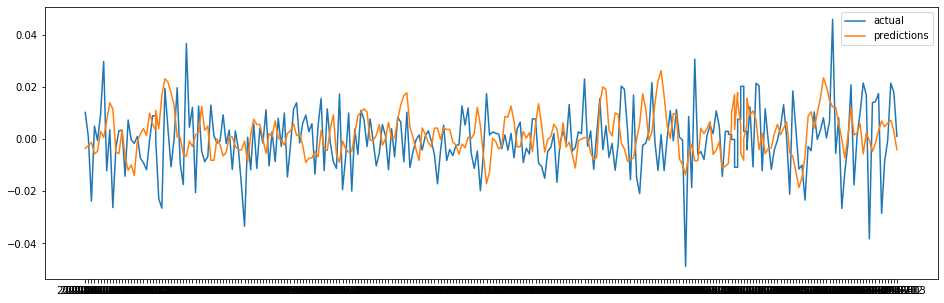

In [152]:
df_test = pd.DataFrame({'date':df_final_test[['datetime']].iloc[-len(Y_test):,:].values.flatten(),
                        'true': Y_test, 'pred':predictions.flatten()})

df_test['close_up_actual'] = np.where(df_test['true'] > 0, 1, 0)
df_test['close_up_pred'] = np.where(df_test['pred'] > 0, 1, 0)

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(df_test['date'], df_test['true'], label='actual')
ax.plot(df_test['date'], df_test['pred'], label='predictions')
ax.legend()

In [153]:
print(f1_score(df_test['close_up_actual'], df_test['close_up_pred']))
print(precision_score(df_test['close_up_actual'], df_test['close_up_pred']))
print(recall_score(df_test['close_up_actual'], df_test['close_up_pred']))
print(accuracy_score(df_test['close_up_actual'], df_test['close_up_pred']))
print(df_test['true'].corr(df_test['pred']) ** 2)

0.484641638225256
0.45222929936305734
0.5220588235294118
0.4489051094890511
0.0003804078770481891


0.00034965534026554327

In [ ]:
api_url = f'https://www.alphavantage.co/query?function=CPI&interval=monthly&apikey={api_key}'
data = requests.get(api_url).json()
df_out = pd.DataFrame(data['data'])
df_out.columns = ['datetime', api]
df_out.columns = df_out.columns.str.lower()
df_out = df_out[(df_out['datetime'] >= self.start_dt) & (df_out['datetime'] <= self.end_dt)]
df_out = df_out.sort_values(['datetime'], ascending=True)

In [56]:
df.columns.tolist()

['ticker',
 'datetime',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'upper_band',
 'middle_band',
 'lower_band',
 'ema',
 'macd',
 'macd_signal',
 'macd_hist',
 'rsi',
 'atr',
 'tenkan_sen',
 'kijun_sen',
 'senkou_span_a',
 'senkou_span_b',
 'chikou_span',
 'vix_close',
 'spy_close',
 'cpi',
 'inflation_expectation',
 'consumer_sentiment',
 'cdl2crows',
 'cdl3blackcrows',
 'cdl3inside',
 'cdl3linestrike',
 'cdl3outside',
 'cdl3starsinsouth',
 'cdl3whitesoldiers',
 'cdlabandonedbaby',
 'cdladvanceblock',
 'cdlbelthold',
 'cdlbreakaway',
 'cdlclosingmarubozu',
 'cdlconcealbabyswall',
 'cdlcounterattack',
 'cdldarkcloudcover',
 'cdldoji',
 'cdldojistar',
 'cdldragonflydoji',
 'cdlengulfing',
 'cdleveningdojistar',
 'cdleveningstar',
 'cdlgapsidesidewhite',
 'cdlgravestonedoji',
 'cdlhammer',
 'cdlhangingman',
 'cdlharami',
 'cdlharamicross',
 'cdlhighwave',
 'cdlhikkake',
 'cdlhikkakemod',
 'cdlhomingpigeon',
 'cdlidentical3crows',
 'cdlinneck',
 'cdlinvertedhammer',
 'cdlkicking',
 '

In [3]:
api_key = '4513da89573e4b9d87fce1afb935b1f0'
tickers = ['AAPL']
interval = '1day'
start_dt = '2021-01-01'
end_dt = '2021-12-31'
#api_url = f'https://api.twelvedata.com/earnings?symbol=AAPL&interval={interval}&order=ASC&start_date={start_dt}&end_date={end_dt}&apikey={api_key}'
api_url = f'https://api.twelvedata.com/earnings?symbol=AAPL&order=ASC&start_date={start_dt}&end_date={end_dt}&apikey={api_key}'
data = requests.get(api_url).json()
df = pd.DataFrame(data['values'])
df['ticker'] = 'AAPL'
df

KeyError: 'values'

In [104]:
tsd = TimeSeriesData(api_key=api_key, tickers=tickers, interval=interval, start_dt=start_dt, end_dt=end_dt)
chk = tsd.get_gap(df)
chk

,datetime,open,high,low,close,volume,ticker,gap
0,2021-01-04,133.52000,133.61000,126.76000,129.41000,143301900,AAPL,NaN
1,2021-01-05,128.89000,131.74001,128.42999,131.00999,97664900,AAPL,-0.004018
2,2021-01-06,127.72000,131.05000,126.38000,126.60000,155088000,AAPL,-0.025113
3,2021-01-07,128.36000,131.63000,127.86000,130.92000,109578200,AAPL,0.013902
4,2021-01-08,132.42999,132.63000,130.23000,132.05000,105158200,AAPL,0.011534
5,2021-01-11,129.19000,130.17000,128.50000,128.98000,100384500,AAPL,-0.021658
6,2021-01-12,128.50000,129.69000,126.86000,128.80000,91951100,AAPL,-0.003722
7,2021-01-13,128.75999,131.45000,128.49001,130.89000,88636800,AAPL,-0.000311
8,2021-01-14,130.80000,131.00000,128.75999,128.91000,90221800,AAPL,-0.000688
9,2021-01-15,128.78000,130.22000,127.00000,127.14000,111598500,AAPL,-0.001008


In [11]:
pd.DataFrame(data['values'])

,datetime,open,high,low,close,volume
0,2021-01-04,36.64000,36.71000,35.37000,35.38000,4967013
1,2021-01-05,35.40000,35.68000,35.31000,35.34000,4432400
2,2021-01-06,35.35000,35.39500,34.97000,35.17000,7383479
3,2021-01-07,35.25000,35.40000,35.01500,35.28000,3433837
4,2021-01-08,35.37000,35.77000,35.32000,35.66000,3419871
5,2021-01-11,35.47000,35.63000,34.95500,35.06000,4050012
6,2021-01-12,34.99000,35.13000,34.65000,35.09000,4372475
7,2021-01-13,35.07000,35.63000,35.07000,35.57000,3024381
8,2021-01-14,35.67000,36.02000,35.50000,35.79000,3792654
9,2021-01-15,35.71000,36.40610,35.63000,36.34000,4212957
